In [ ]:
# Install Statements

!pip install "dask[dataframe]"
!pip install cftime
!pip install utils
!pip install netCDF4 
!pip install scipy 
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Statements

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import cdist
from numpy.random import uniform
import seaborn as sns
import random
import dask.dataframe as dd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import sys 
import  pandas
from netCDF4 import Dataset
import matplotlib as mpl 
import matplotlib.colors as colors

In [ ]:
# Piece of code to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# All the xarray datasets are opened into various variables

mdata_4 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock_v4.nc')
mdata_3_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock3.1.nc')
mdata_2_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock2.1.nc')
mdata_1 = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/mock1.nc')
rdata_daily = xr.open_dataset('/content/drive/MyDrive/Courses/IS-700-Independent_Study/ERA5_meteo_sfc_2021_daily.nc').rename({'latitude':'lat','longitude':'lon'})

In [ ]:
# data = data.drop_vars('sst')

In [ ]:
# This dictionary holds the names of all the xarray files and the files themselves
data = {'mdata_4':mdata_4,'mdata_3_1':mdata_3_1,'mdata_2_1':mdata_2_1,'mdata_1':mdata_1,'rdata_daily':rdata_daily}

### Elbow Curve Method
To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.

In [ ]:
from pandas.core.frame import DataFrame
def datatransformation(data):

        '''This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and,
        pairs of both dimensions "latitude" and "longitude" will become the columns for each variable'''

        # The below line will convert the xarray into a dask dataframe
        dask_df = data.to_dask_dataframe(dim_order=None, set_index=False)
        # The below line will convert the dask dataframe into a pandas dataframe
        pd_df = dask_df.compute()

        # The below loop will handle missing values in each and every column of the dataframe by substituting mean of individual columns in the place of the missing values
        for i in pd_df.columns:
          if pd_df[i].isna().sum() > 0:
            pd_df[i].fillna(value=pd_df[i].mean(), inplace=True)
        
        # Since the pandas dataframe (p_df) will also have the dimensions of the xarray as columns, we'll have to remove them. Below code handles that part.
        col = 'time','lat','lon'
        fin_df = pd_df.loc[:, ~pd_df.columns.isin(col)]

        # trans_data will be the final dataframe that the function will return.
        trans_data = pd.DataFrame()
        for j in fin_df.columns:
          for i in range(0,pd_df.shape[0]):
              c=(j + '(' + str(pd_df.lat[i])+','+str(pd_df.lon[i]) + ')') # Every variable followed by the pairs of latitude and longitude will become the columns
              trans_data.loc[pd_df.time[i], c] = pd_df[j][i] # Based on the column name (var+ (lat,lon)), the correct value of each variable will sit in the right place.

        return trans_data

def datanormalization(input):
  ''' This function is used to normalize the data that is passed to it. Input in this case will be the transformed pandas dataframe. '''
  x = input.values # returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  x_scaled = min_max_scaler.fit_transform(x) # x_scaled will hold the values of the normalized data
  
  # trans_data will hold the same columns and index of the dataframe that is passed to it. And the values will be the ones saved in x_scaled
  trans_data = pd.DataFrame(x_scaled, columns=input.columns, index=input.index)
        
  return trans_data    


def PCA_transform(input):
  ''' This function is used to implement Principal Component Analysis, which is often used as a dimension reduction technique.'''
  # https://talkingdatascience.com/principal-component-analysis/

  # Center the data with mean-correction 
  data_centered = input.apply(lambda x: x-x.mean())
  

  # Perform PCA()
  # If a float value between 0 and 1 is passed as n_components, it means that this percentage of variance of the original data will be preserved in the principal components.
  pca = PCA(n_components=0.95) 
  pca.fit(data_centered)

  # Get pca scores
  pca_scores = pca.transform(data_centered)

  # Convert pca_scores to a dataframe
  scores_df = pd.DataFrame(pca_scores)

  # Round to two decimals
  scores_df = scores_df.round(2)

  # Return scores
  return scores_df 

In [ ]:
# ''' In this piece of code, every xarray file that is mentioned in the 'data' dictionary will be transformed into a pandas dataframe using the data transformation 
# function defined earlier and saved to the specified folder on Google drive.'''

# trans_data = {}
# for i in data:
#   trans_data[str(i)] = datatransformation(data[i])
#   path = str(i)
#   fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")
#   trans_data[str(i)].to_csv(fullpath,index=True)

In [ ]:
# Loading the saved transformed data files into the below variables.
mdata_4_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_4.csv', index_col=[0])
mdata_3_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_3_1.csv', index_col=[0])
mdata_2_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_2_1.csv', index_col=[0])
mdata_1_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/mdata_1.csv', index_col=[0])
rdata_daily_trans = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/rdata_daily.csv', index_col=[0])

# Trans_data_saved will be the dictionary that holds all of these variables.
trans_data_saved = {'mdata_4_trans':mdata_4_trans,'mdata_3_1_trans':mdata_3_1_trans,'mdata_2_1_trans':mdata_2_1_trans,'mdata_1_trans':mdata_1_trans,'rdata_daily_trans':rdata_daily_trans}


Elbow curves of mdata_4_trans are as follows:
Distortion Values:
1 : 570.5510625076183
2 : 111.6068438519932
3 : 5.408326913195984
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 6518345.0
2 : 452295.0
3 : 1170.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


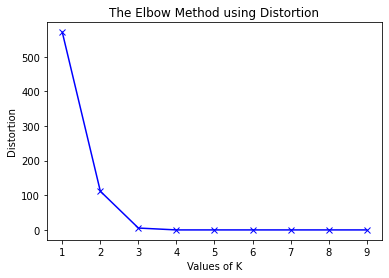

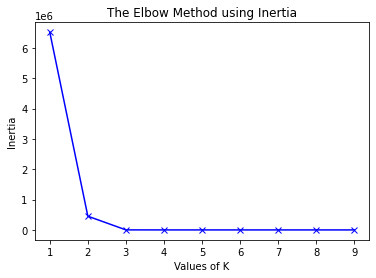



Elbow curves of mdata_3_1_trans are as follows:
Distortion Values:
1 : 822.6774843841238
2 : 263.0598537152418
3 : 12.74754878398196
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 13651375.0
2 : 2512750.0
3 : 6500.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


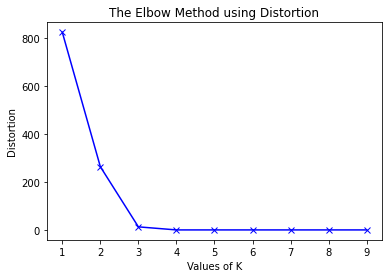

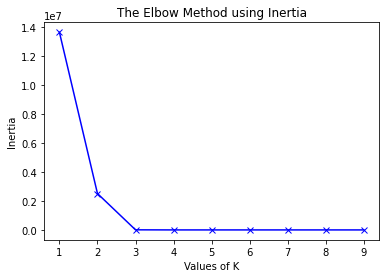



Elbow curves of mdata_2_1_trans are as follows:
Distortion Values:
1 : 393.08475549173886
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 3090312.5
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


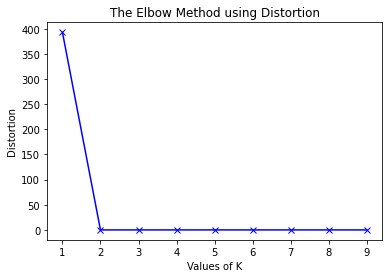

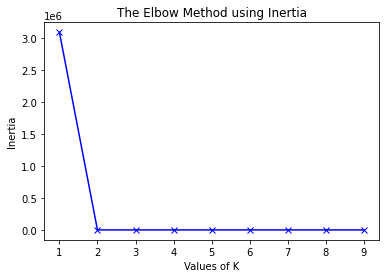



Elbow curves of mdata_1_trans are as follows:
Distortion Values:
1 : 497.51884386423006
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0

Inertia Values:
1 : 4950500.0
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0


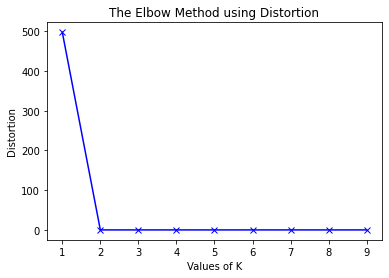

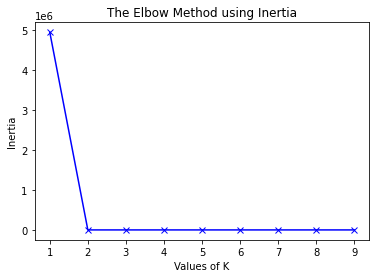



Elbow curves of rdata_daily_trans are as follows:
Distortion Values:
1 : 8844656.77585766
2 : 7073924.215067062
3 : 6246032.308339245
4 : 5882937.157021162
5 : 5614438.894475746
6 : 5330497.95197867
7 : 5200327.358792777
8 : 5014158.483828699
9 : 4937986.558447357

Inertia Values:
1 : 3.710226699981823e+16
2 : 2.196535732754648e+16
3 : 1.694508907201236e+16
4 : 1.4813973003127958e+16
5 : 1.3175331421647648e+16
6 : 1.2142510084441124e+16
7 : 1.1335233965710134e+16
8 : 1.053909577429564e+16
9 : 1.0208340522019214e+16


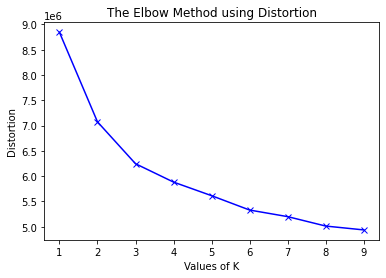

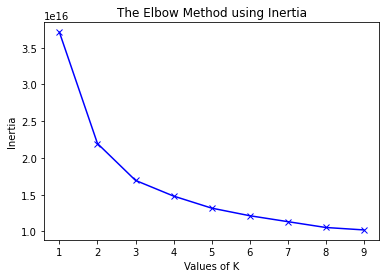

In [ ]:
# Define distortion and inertia above this cell. Use info that is available on geeksforgeeks

# Declaring lists that will capture the values of distortion and inertia
distortions = []
inertias = []

# Declaring dictionaries that will map the values of k and distortion, inertia values respectively
mapping1 = {}
mapping2 = {}

# Value of K will range from 1 to 10
K = range(1, 10)

# For all the transformed pandas dataframes, elbow curve plots will be printed in the following loop.
for i in trans_data_saved:  
  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(trans_data_saved[i])
      kmeanModel.fit(trans_data_saved[i])

      # Values of distortion will be appended to the list declared above
      distortions.append(sum(np.min(cdist(trans_data_saved[i], kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / trans_data_saved[i].shape[0])
      # Values of inertia will be appended to the list declared above
      inertias.append(kmeanModel.inertia_)

      # The below two lines of code will handle the mapping of k with distortion and inertia values.
      mapping1[k] = sum(np.min(cdist(trans_data_saved[i], kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / trans_data_saved[i].shape[0]
      mapping2[k] = kmeanModel.inertia_
  print()
  print('Elbow curves of', i, 'are as follows:')
  print('Distortion Values:')
  for key, val in mapping1.items():
      print(f'{key} : {val}')    
  print()
  print('Inertia Values:')
  for key, val in mapping2.items():
      print(f'{key} : {val}')

  # The below lines of code will generate plots with the distortion values
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()

  # The below lines of code will generate plots with the inertia values
  plt.plot(K, inertias, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method using Inertia')
  plt.show()
  print()
  distortions = []
  inertias = []  
  mapping1 = {}
  mapping2 = {}

### Implementing the algorithm by using the actual data

In [ ]:
# Fit and Evaluate functions with PCA as a parameter

def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
    

class KMeans:
    def __init__(self, n_clusters, max_iter=500):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, xarray_data, PCA = True, pass_trans_data = True):

      ''' This function fits the K-means model to the data that is passed to it.
          Parameters that this function will accept are as follows:
          1. xarray_data = string of the name of the original xarray file
          2. PCA (bool) = whether or not PCA has to be applied. Default value is True
          3. pass_trans_data (bool) = whether saved data has to be passed. If False, data will be transformed instantly. Default value is True.'''

      # The following block will run if user wants PCA to be applied to the data
      if PCA == True:
        # The following code will be executed if the user wants the saved transformed dataframe to be considered.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list which holds the values of the parameters that are being passed to the function
          path = str(k[1]) # path will hold the first parameter's value
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X_train = pd.read_csv(fullpath, index_col=[0]) # saved transformed dataframe will be read
          X_train = datanormalization(X_train) # the data will be normalized
          X_train = np.array(PCA_transform(X_train)) # X_train in the form of a numpy array will hold the data to which PCA has been applied 

        

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
              then the rest are initialized with probabilities proportional to their distances to the first point.'''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]

          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1

        # If the user does not want the saved transformed data to be used, the below block of code will be executed    
        else:
          X_train = datatransformation(xarray_data) # Transforming the data
          X_train = datanormalization(X_train) # Normalizing the data
          X_train = np.array(PCA_transform(X_train)) # Applying PCA to the data and storing it in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
              then the rest are initialized with probabilities proportional to their distances to the first point.'''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1      

      # If the user does not want PCA to be applied to the data, the below block of code will be executed
      else:
        # The following code will be executed if the user wants the saved transformed dataframe to be considered.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list which holds the values of the parameters that are being passed to the function
          path = str(k[1]) # path will hold the first parameter's value
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X_train = pd.read_csv(fullpath, index_col=[0]) # saved transformed dataframe will be read
          X_train = np.array(datanormalization(X_train)) # the data will be normalized and stored in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
          # then the rest are initialized with probabilities proportional to their distances to the first point. '''
          
          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, and assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids) # Calling the function defined above
                  centroid_idx = np.argmin(dists) # Assigning points to the nearest centroid
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1

        # If the user does not want the saved transformed data to be used, the below block of code will be executed        
        else:
          X_train = datatransformation(xarray_data) # Transforming the data
          X_train = np.array(datanormalization(X_train)) # Normalizing the data and storing it in the form of a numpy array

          ''' Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first point,
           then the rest are initialized w/ probabilities proportional to their distances to the first point.'''

          # Pick a random point from train data for first centroid
          self.centroids = [random.choice(X_train)]
          for _ in range(self.n_clusters-1):
              # Calculate distances from points to the centroids
              dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
              # Normalize the distances
              dists /= np.sum(dists)
              # Choose remaining points based on their distances
              new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
              self.centroids += [X_train[new_centroid_idx]]

          iteration = 0 # setting iteration to 0
          prev_centroids = None # setting prev_centroids to None

          while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
              # Sort each datapoint, assign it to the nearest centroid
              sorted_points = [[] for _ in range(self.n_clusters)]
              for x in X_train:
                  dists = euclidean(x, self.centroids)
                  centroid_idx = np.argmin(dists)
                  sorted_points[centroid_idx].append(x)
              # Push current centroids to previous, reassign centroids as mean of the points belonging to them
              prev_centroids = self.centroids
              self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
              for i, centroid in enumerate(self.centroids):
                  if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                      self.centroids[i] = prev_centroids[i]
              iteration += 1


    def evaluate(self, z, PCA = True, pass_trans_data = True):
      ''' This function evaluates and assigns data points to clusters
          Parameters that this function will accept are as follows:
          1. z = string of the name of the original xarray file
          2. PCA (bool) = whether or not PCA has to be applied. Default value is True.
          3. pass_trans_data (bool) = whether saved data has to be passed. If False, data will be transformed instantly. Default value is True.'''
      
      # The following block of code will be executed if the user wants PCA to be applied to the data.
      if PCA == True:
        # The following code will be executed if the user wants the function to consider already saved transformed data.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list that holds the values of all the parameters that are being passed to the function
          path = str(k[1]) # path will capture the value of the first parameter
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X = pd.read_csv(fullpath,index_col=[0]) # Already saved transformed dataframe will be read
          Y = datanormalization(X) # Data will be normalized here
          Y = np.array(PCA_transform(Y)) # PCA will be applied to the data and stored as a numpy array.

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []

          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          transformed_data['clusterid'] = centroid_idx 

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']] #+ [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data # Storing the data along with the index
          transformed_data = transformed_data.reset_index() # Resetting the index of the dataframe

          return centroid, centroid_idx, transformed_data

        # If the user does not want saved data to be considered by the function, the below block will be executed
        else:
          X = datatransformation(z) # Transforming the original data into a pandas dataframe
          Y = datanormalization(X) # Normalizing the transformed data
          Y = np.array(PCA_transform(Y)) # Applying PCA to the data and storing it as a numpy array

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []
          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          transformed_data['clusterid'] = centroid_idx

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']]# + [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()

          return centroid, centroid_idx, transformed_data

      # The following block of code will be executed if the user does not want PCA to be applied to the data.
      else:
        # If the user wants already saved transformed data to be considered, the below code will be executed.
        if pass_trans_data == True:
          k = list(locals().values()) # k will be the list that holds the values of all the parameters that are being passed to the function
          path = str(k[1]) # path will hold the value of the first parameter
          fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")

          X = pd.read_csv(fullpath,index_col=[0]) # Already saved transformed data will be read
          Y = np.array(datanormalization(X)) # The data will be normalized and saved as a numpy array.

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []

          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding class centers and cluster numbers as columns to the dataframe
          # transformed_data['Class_Center'] = centroid
          transformed_data['clusterid'] = centroid_idx   

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']]# + [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()

          return centroid, centroid_idx, transformed_data

        # If the user does not want saved data to be considered by the function, the below block will be executed
        else:
          X = datatransformation(z) # Transforming the original data into a pandas dataframe
          Y = np.array(datanormalization(X)) # Normalizing the data and saving it as a numpy array

          # Declaring empty lists that will later hold the values of class_center and classification (1d array output)
          centroid = []
          centroid_idx = []
          i=0
          for x in Y:
              dists = euclidean(x, self.centroids) # Calling the function defined earlier
              centroid_id = np.argmin(dists) # Assigning the points to their nearest centroid
              centroid.append(self.centroids[centroid_id]) # Appending the class_centers
              centroid_idx.append(centroid_id) # Appending the cluster labels

          # The following steps will save the transformed data so that it can be used for visualization at a later stage.
          # Converting the normalized data array into a pandas dataframe
          transformed_data = pd.DataFrame(Y, index=X.index)

          # Adding cluster numbers as a column to the dataframe
          transformed_data['clusterid'] = centroid_idx

          # Rearranging the columns in the dataframe
          transformed_data = transformed_data[['clusterid']] #+ [c for c in transformed_data if c not in ['clusterid']]]
          transformed_data1 = transformed_data
          transformed_data = transformed_data.reset_index()              

          return centroid, centroid_idx, transformed_data

In [ ]:
# Function to modify the dataframe returned by the evaluate function.

def modify_date(df):
  # This function will accept a dataframe as an input.

  # Since the dataframe returned by the evaluate function has date as a string, the following line will convert it to the specified date format.
  df['index'] = pd.to_datetime(df['index'], format='%Y-%m-%d') 
  # A new column called time_step will be added which will have the year followed by the day of the year.
  df['time_step'] = df['index'].dt.strftime("%Y-%j")
  # Dropping the column 'index'
  df = df.drop(['index'], axis=1)
  return df

In [ ]:
# Function that saves the modified dataframe

def save_df(df,df_name):
  # This function will accept a dataframe and its name as an input.

  # The following code will save the dataframe to the location specified below.
  path = '/content/drive/MyDrive/Courses/IS-700-Independent_Study/'+df_name+'.csv'
  df.to_csv(path,index=True)
  return

# **Fitting the model to every data file.**

## **Mock_v4.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_4',PCA=True,pass_trans_data=True)

class_centers_mdata_4, classification_mdata_4, transformed_data_mdata_4 = kmeans.evaluate('mdata_4',PCA=True,pass_trans_data=True)
transformed_data_mdata_4 = modify_date(transformed_data_mdata_4)
save_df(transformed_data_mdata_4,'transformed_data_mdata_4')

classification_mdata_4

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]

## **Mock_v3.1.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_3_1',PCA=True,pass_trans_data=True)

class_centers_mdata_3_1, classification_mdata_3_1, transformed_data_mdata_3_1 = kmeans.evaluate('mdata_3_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_3_1 = modify_date(transformed_data_mdata_3_1)
save_df(transformed_data_mdata_3_1,'transformed_data_mdata_3_1')

classification_mdata_3_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]

## **Mock_v2.1.nc**

In [ ]:
centers = 2
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_2_1',PCA=True,pass_trans_data=True)

class_centers_mdata_2_1, classification_mdata_2_1, transformed_data_mdata_2_1 = kmeans.evaluate('mdata_2_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_2_1 = modify_date(transformed_data_mdata_2_1)
save_df(transformed_data_mdata_2_1,'transformed_data_mdata_2_1')

classification_mdata_2_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## **Mock_v1.nc**

In [ ]:
centers = 2
kmeans = KMeans(n_clusters=centers)
kmeans.fit('mdata_1',PCA=True,pass_trans_data=True)

class_centers_mdata_1, classification_mdata_1, transformed_data_mdata_1 = kmeans.evaluate('mdata_1',PCA=True,pass_trans_data=True)
transformed_data_mdata_1 = modify_date(transformed_data_mdata_1)
save_df(transformed_data_mdata_1,'transformed_data_mdata_1')

classification_mdata_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## **ERA5_meteo_sfc_2021_daily.nc**

In [ ]:
centers = 3
kmeans = KMeans(n_clusters=centers)
kmeans.fit('rdata_daily',PCA=True,pass_trans_data=True)

class_centers_rdata_daily, classification_rdata_daily, transformed_data_rdata_daily = kmeans.evaluate('rdata_daily',PCA=True,pass_trans_data=True)
transformed_data_rdata_daily = modify_date(transformed_data_rdata_daily)
save_df(transformed_data_rdata_daily,'transformed_data_rdata_daily')

classification_rdata_daily

[2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


#**Evaluation - RMSE** 

### RMSE - Non-normalized functions





In [ ]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster

def get_datewise_clusters(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results'''

  Dates_Cluster = {} # declaring a dictionary
  input1 = data[input] # This line will fetch the actual xarray data file from the 'data' dictionary based on the name that is passed as input.
  input = input+'_trans' # This is how the data is stored in the trans_data_saved dictionary
  transdata = trans_data_saved[input] # transdata will hold the saved transformed data for the given input
  transdata['Cluster'] = formed_clusters # Adding a column called cluster that will hold the clustering results.
  transdata = transdata[['Cluster'] + [c for c in transdata if c not in ['Cluster']]] # Rearranging the columns
  transdata1 = transdata # Saving the transformed data along with the index
  transdata = transdata.reset_index() # Resetting the index

  # Iterating over the distinct values of the clusters formed
  for i in set(formed_clusters):
    # All the dates (index in this case) that have a specific cluster id will go into the dictionary as a list against the specific key
    # Every key in the dictionary will have a list as its value, where the list will hold the dates that belong to a specific cluster
    Dates_Cluster['Dates_Cluster'+str(i)] = transdata.index[transdata.Cluster == i].to_list()

  # The final dictionary will all the keys and their respective lists (as values) will be returned.
  return Dates_Cluster

In [ ]:
# Non-normalized
# Function that creats a dictionary that holds all the clusters.

def n_nor_get_clusters(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results'''

     
  com_arr = [] # Declaring a list that will hold every variable's data for a single day
  Clusters = {} # Declaring a dictionary that will hold the entire data of all days, based on the cluster number
  input1 = data[input] # This line will fetch the actual xarray data file from the 'data' dictionary based on the name that is passed as input.
  Dates_Cluster = get_datewise_clusters(input,formed_clusters) # Calling the function declared earlier

  # For all the distinct cluster numbers in the 1-d array (clustering results)
  for i in set(formed_clusters):
    # For each day in the specific Dates_Cluster
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input1.isel(time=j).to_array()) # A single day's data of all the variables will be stored in arr in the form of a numpy array
      com_arr.append(arr) # arr is appended to the list 'com_arr'
    Clusters['Cluster' + str(i)] = np.array(com_arr) # One key in the dictionary will hold the entire data of all the days that belong to a specific cluster id
    com_arr = [] # com_arr is reset

  # This dictionary is returned.    
  return Clusters    

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results'''


  Cluster_Centers = {} # Declaring a dictionary that will hold the cluster_centers for every cluster formed
  input1 = data[input] # This line will fetch the actual xarray data file from the 'data' dictionary based on the name that is passed as input.
  Clusters = n_nor_get_clusters(input,formed_clusters) # Calling the function defined earlier

  # For all the distinct cluster numbers in the 1-d array (clustering results)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0) # Mean of the cluster is computed and stored against the specific key.

  # This dictionary is returned.
  return Cluster_Centers

In [ ]:
# Non-normalized 
#Intra RMSE Calculation Function for Non-normalized data
def n_nor_intra_rmse(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results'''

  
  sq_diff = []
  intra_rmse = []
  input1 = data[input] # This line will fetch the actual xarray data file from the 'data' dictionary based on the name that is passed as input.
  Clusters = n_nor_get_clusters(input,formed_clusters) # Dictionary that holds the data of all the clusters formed
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)  # Dictionary that holds the cluster centers of every cluster formed

  # For all the clusters that have been formed
  for i in range(len(Clusters)):
    # For all the points that belong to cluster i
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)] # Distance between each point and the cluster center is determined
      Sq_diff = (diff**2) # The distance is squared
      sq_diff.append(Sq_diff) # The squared distance is appended to the list sq_diff
    Sq_diff_sum = sum(sq_diff) # This variable will hold the sum of all the squared distances
    sq_diff = [] # sq_diff is reset to an empty list again
    n = len(Clusters['Cluster' + str(i)]) # The number of points within a cluster
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n)))) # RMSE within a particular cluster is determined here.
    intra_rmse.append(Sqrt_diff_sum) # The RMSE score is appended to intra_rmse

  # The list with all the RMSE scores is returned    
  return intra_rmse

In [ ]:
# Non-normalized
# Function that handles the missing values in a particular xarray data file
def handle_missing_values(input):
  # This function takes the xarray file as an input
  var_mean = {}
  # For all the variables within the file
  for i in input.data_vars:
    # If the number of missing values is greater than 0
    if input[i].isnull().sum().item() > 0:
      var_mean[str(i) + '_mean'] = input[i].mean().item() # Computing the mean of the variable within the data
      input[i] = input[i].fillna(var_mean[str(i) + '_mean']) # Filling the missing values with the computed mean
      print('Null values in',i,'have been handled.')

  # The xarray data file without missing values is returned      
  return input

### RMSE - Normalized functions

In [ ]:
# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers of the normalized data
def nor_get_clusters_and_centers(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
      1. Name of the xarray file as string
      2. 1-d array that has the clustering results'''
  
  # Declaring two dictionaries that will hold the clusters and cluster centers.
  Clusters = {}
  Cluster_Centers = {}

  # For all the distinct cluster numbers in the 1-d array (clustering results)
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster'])) # data of every cluster are captured into this dictionary
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0) # cluster centers of every cluster are captured into this dictionary

  # Both the dictionaries are returned
  return Clusters,Cluster_Centers

In [ ]:
# Normalized
# Intra RMSE Calculation Function
def nor_intra_rmse(input,formed_clusters):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results'''

  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters) # Calling a function to get clusters and cluster centers

  # For all the clusters that have been formed
  for i in range(len(Clusters)):
    # For all the points within cluster i
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)] # Difference between a point and the cluster center
      Sq_diff = (diff**2) # Square of the distance
      sq_diff.append(Sq_diff) # The difference sqare is appended to the list sq_diff
    Sq_diff_sum = sum(sum(sq_diff)) # This holds the value of the sum of all the differences between all the points and the cluster center
    sq_diff = [] # Resetting sq_diff to an empty list
    n = len(Clusters['Cluster' + str(i)]) # Number of points within each cluster
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n) # RMSE within a particular cluster is determined here.
    intra_rmse.append(Sqrt_diff_sum) # The RMSE score is appended to intra_rmse.
  return intra_rmse

In [ ]:
# RMSE Calculation with 5th parameter
def RMSE(input,formed_clusters,normalize=False,pass_trans_data=False,PCA=False):
  ''' The parameters accepted by this function are as follows:
    1. Name of the xarray file as string
    2. 1-d array that has the clustering results
    3. Normalize (bool) = whether or not the data has to be normalized. Default value is False
    4. pass_trans_data (bool) = whether or not saved transformed data has to be passed. Default value is True
    5. PCA (bool) = whether or not PCA has to be applied. Default value is False.'''

  inter_rmse = []
  avg_cluster = {}
  input1 = data[input] # This line fetches the actual xarray data file from the 'data' dictionary that was defined at the bery beginning.

  # If the user does not want the data to be normalized, the below block of code is executed
  if normalize == False:
    input1 = handle_missing_values(input1) # This line handles any missing data in the data file.
    Clusters = n_nor_get_clusters(input,formed_clusters) # A function that was earlier defined is called to get the clusters in the data
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters))) # mat is a dataframe having the total number of clusters as both, the rows and columns.
    # For all the clusters that have been formed
    for i in range(len(Clusters)):
      # Cluster centers are determined using the below line and stored in the 'avg_cluster' dictionary.
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    # For all the clusters that have been formed
    for i in range(len(Clusters)):
      # For all the clusters that have been formed
      for j in range(len(Clusters)):
        if i == j:
          # Intra RMSE function is called if i and j take the same cluster id
          a = n_nor_intra_rmse(input,formed_clusters)
          # Values are entered in the dataframe 'mat'
          mat[i].iloc[j] = round(a[i],2) # Values are rounded to two decimal points
         
         # If i and j do not have the same value, inter RMSE is calculated 
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)] # Difference between both the cluster centers
          Sq_diff = (diff**2) # Difference is then sqaured
          Sq_diff_sum = sum(sum(sum(Sq_diff))) # This holds the value of sum of all the differences
          n = len(avg_cluster['avg_cluster'+str(i)][0]) 
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n) # Final RMSE score is computed here.
          mat[i].iloc[j] = round(Sqrt_diff_sum,2) # Scores are assigned to their respective positions
    return mat       

  # If the user wants the data to be normalized, the below code is executed
  else:
    # If the user wants PCA to be applied, the following code is executed
    if PCA == True:
      # IF the user wants saved transformed data to be considered, the below code is executed
      if pass_trans_data == True:
        k = list(locals().values()) # k is a list which holds the values of all the parameters that are passed to the function
        path = str(k[0]) # path holds the first parameter's value
        fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv") 
        X = pd.read_csv(fullpath,index_col=[0]) # Saved transformed file is read
        Y = datanormalization(X) # The data is normalized
        Y = PCA_transform(Y) # PCA is applied to the data

        Y['Cluster'] = formed_clusters # Adding a new column to the data which the clustering results
        Y = Y[['Cluster'] + [c for c in Y if c not in ['Cluster']]] # Rearranging the columns of the dataframe
  
        Clusters, Cluster_Centers = nor_get_clusters_and_centers(Y,formed_clusters) # Function to get clusters and cluster centers is called
  
        mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters))) # mat is a dataframe having the total number of clusters as both, the rows and columns.
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # Cluster center is computed at this stage
          avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # For all the clusters that have been formed
          for j in range(len(Clusters)):
            # If i and j refer to the same cluster
            if i == j: 
              a = nor_intra_rmse(Y,formed_clusters) # Intra RMSE function is called
              mat[i].iloc[j] = round(a[i],2) # Respective scores are entered in the dataframe
            # If i and j do not refer to the same cluster
            else:
              diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)] # Difference between the two cluster centers is computed
              Sq_diff = (diff**2) # The difference is squared
              Sq_diff_sum = sum(Sq_diff) # This variable holds the sum of the distance sqaure
              Sqrt_diff_sum = np.sqrt(Sq_diff_sum) # RMSE score is determined here
              mat[i].iloc[j] = round(Sqrt_diff_sum,2) # Scores are entered to their respective positions
        return mat

      # If the user does not want saved transformed data to be considered, the below block is executed
      else:
        transformed_data = datatransformation(input1) # The actual xarray file is transformed to a pandas dataframe

        # Data Normalization
        transformed_data = datanormalization(transformed_data) # The transformed data is normalized

        # Applying PCA
        transformed_data = PCA_transform(transformed_data) # PCA is applied to the normalized data

        # Adding cluster numbers as a column to the dataframe
        transformed_data['Cluster'] = formed_clusters

        # Rearranging the columns in the dataframe
        transformed_data = transformed_data[['Cluster'] + [c for c in transformed_data if c not in ['Cluster']]]
  
        Clusters, Cluster_Centers = nor_get_clusters_and_centers(transformed_data,formed_clusters) # Function to get the clusters and their centers is called
  
        mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters))) # mat is a dataframe having the total number of clusters as both, the rows and columns.
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0) # Cluster center is determined here
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # For all the clusters that have been formed
          for j in range(len(Clusters)):
            # If i and j refer to the same cluster
            if i == j:
              a = nor_intra_rmse(transformed_data,formed_clusters) # Intra RMSE function is called
              mat[i].iloc[j] = round(a[i],2) # Intra RMSE scores are entered in their respective positions
            # If i and j refer to two different clusters
            else:
              diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)] # Difference between the two cluster centers is computed
              Sq_diff = (diff**2) # The distance is squared
              Sq_diff_sum = sum(Sq_diff) # This variable holds the sum of the squared distance
              Sqrt_diff_sum = np.sqrt(Sq_diff_sum) # RMSE score is determined here
              mat[i].iloc[j] = round(Sqrt_diff_sum,2) # Inter RMSE scores are entered to their respective positions

        return mat

    # If the user does not want PCA to be applied, the below code is executed
    else:
      # If the user wants saved transformed data to be considered, the below code is run
      if pass_trans_data == True:
        k = list(locals().values()) # k is a list which holds the values of the parameters that are passed to the function
        path = str(k[0]) # path holds the value of the first parameter
        fullpath = os.path.join("/content/drive/MyDrive/Courses/IS-700-Independent_Study/Transformed_data/" + path + ".csv")
        X = pd.read_csv(fullpath,index_col=[0]) # Saved transformed file is read
        Y = datanormalization(X) # The data is normalized

        Y['Cluster'] = formed_clusters # Adding a new column to the dataframe with the clustering results
        Y = Y[['Cluster'] + [c for c in Y if c not in ['Cluster']]] # Rearranging the columns of the dataframe
  
        Clusters, Cluster_Centers = nor_get_clusters_and_centers(Y,formed_clusters) # Function to get the clusters and their centers is called

        mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters))) # mat is a dataframe having the total number of clusters as both, the rows and columns.
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # Cluster centers are computed and added to the dictionary
          avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # For all the clusters that have been formed
          for j in range(len(Clusters)):
            # If i and j refer to the same cluster
            if i == j:
              a = nor_intra_rmse(Y,formed_clusters) # Intra RMSE function is called
              mat[i].iloc[j] = round(a[i],2) # Intra RMSE scores are entered to their respective places
            # If i and j do not refer to the same cluster
            else:
              diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)] # Distance between their cluster centers is computed
              Sq_diff = (diff**2) # The distance is squared
              Sq_diff_sum = sum(Sq_diff) # This variable holds the sum of the squared distances
              Sqrt_diff_sum = np.sqrt(Sq_diff_sum) # Inter RMSE score is computed here
              mat[i].iloc[j] = round(Sqrt_diff_sum,2) # Inter RMSE scores are entered to their respective places
        return mat

      # If the user does not want saved transformed data to be considered, the below block is executed
      else:
        transformed_data = datatransformation(input1) # The xarray file is transformed to a pandas dataframe

        # Data Normalization
        transformed_data = datanormalization(transformed_data) # The transformed data is normalized

        # Adding cluster number as a column to the dataframe
        transformed_data['Cluster'] = formed_clusters

        # Rearranging the columns in the dataframe
        transformed_data = transformed_data[['Cluster'] + [c for c in transformed_data if c not in ['Cluster']]]
  
        Clusters, Cluster_Centers = nor_get_clusters_and_centers(transformed_data,formed_clusters) # Function to get the clusters and their centers is called

        mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters))) # mat is a dataframe having the total number of clusters as both, the rows and columns.
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # Cluster centres are computed
          avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
        # For all the clusters that have been formed
        for i in range(len(Clusters)):
          # For all the clusters that have been formed
          for j in range(len(Clusters)):
            # If i and j refer to the same cluster
            if i == j:
              a = nor_intra_rmse(transformed_data,formed_clusters) # Intra RMSE function is called
              mat[i].iloc[j] = round(a[i],2) # Intra RMSE scores are entered to their respective places
            # If i and j do not refer to the same cluster
            else:
              diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)] # Difference between their cluster centers is calculated
              Sq_diff = (diff**2) # The difference is squared
              Sq_diff_sum = sum(Sq_diff) # This variable holds the sum of all the squared distances
              Sqrt_diff_sum = np.sqrt(Sq_diff_sum) # Inter RMSE score is determined here
              mat[i].iloc[j] = round(Sqrt_diff_sum,2) # Inter RMSE scores are entered to their respective places

        return mat


# **RMSE scores of each file in combinations** 

## **Mock_v4.nc**

In [ ]:
final1_0 = RMSE('mdata_4',classification_mdata_4,normalize=True,pass_trans_data=True,PCA=True)
final1_0

,0,1,2
0,0.0,13.55,0.07
1,13.55,0.02,13.48
2,0.07,13.48,0.0


In [ ]:
final1_1 = RMSE('mdata_4',classification_mdata_4,normalize=True,pass_trans_data=False,PCA=False)
final1_1

,0,1,2
0,0.0,13.6,2.47
1,13.6,0.63,13.54
2,2.47,13.54,0.0


In [ ]:
final1_2 = RMSE('mdata_4',classification_mdata_4,normalize=False,pass_trans_data=False,PCA=False)
final1_2

,0,1,2
0,0.0,354.78,134.33
1,354.78,10.82,354.68
2,134.33,354.68,0.0


## **Mock_v3.1.nc**

In [ ]:
final2_0 = RMSE('mdata_3_1',classification_mdata_3_1,normalize=True,pass_trans_data=True,PCA=True)
final2_0

,0,1,2
0,0.63,10.94,10.94
1,10.94,0.0,5.6
2,10.94,5.6,0.0


In [ ]:
final2_1 = RMSE('mdata_3_1',classification_mdata_3_1,normalize=True,pass_trans_data=False,PCA=False)
final2_1

,0,1,2
0,1.25,10.95,10.95
1,10.95,0.0,5.61
2,10.95,5.61,0.0


In [ ]:
final2_2 = RMSE('mdata_3_1',classification_mdata_3_1,normalize=False,pass_trans_data=False,PCA=False)
final2_2

,0,1,2
0,25.5,497.83,497.83
1,497.83,0.0,316.62
2,497.83,316.62,0.0


## **Mock_v2.1.nc**

In [ ]:
final3_0 = RMSE('mdata_2_1',classification_mdata_2_1,normalize=True,pass_trans_data=True,PCA=True)
final3_0

,0,1
0,0.0,14.14
1,14.14,0.0


In [ ]:
final3_1 = RMSE('mdata_2_1',classification_mdata_2_1,normalize=True,pass_trans_data=False,PCA=False)
final3_1

,0,1
0,0.0,14.14
1,14.14,0.0


In [ ]:
final3_2 = RMSE('mdata_2_1',classification_mdata_2_1,normalize=False,pass_trans_data=False,PCA=False)
final3_2

,0,1
0,0.0,248.61
1,248.61,0.0


## **Mock_v1.nc**

In [ ]:
final4_0 = RMSE('mdata_1',classification_mdata_1,normalize=True,pass_trans_data=True,PCA=True)
final4_0

,0,1
0,0.0,14.14
1,14.14,0.0


In [ ]:
final4_1 = RMSE('mdata_1',classification_mdata_1,normalize=True,pass_trans_data=False,PCA=False)
final4_1

,0,1
0,0.0,14.14
1,14.14,0.0


In [ ]:
final4_2 = RMSE('mdata_1',classification_mdata_1,normalize=False,pass_trans_data=False,PCA=False)
final4_2

,0,1
0,0.0,314.66
1,314.66,0.0


## **ERA5_meteo_sfc_2021_daily.nc**

In [ ]:
final5_0 = RMSE('rdata_daily',classification_rdata_daily,normalize=True,pass_trans_data=True,PCA=True)
final5_0

,0,1,2
0,12.27,19.94,33.38
1,19.94,15.46,19.42
2,33.38,19.42,17.86


In [ ]:
final5_1 = RMSE('rdata_daily',classification_rdata_daily,normalize=True,pass_trans_data=True,PCA=False)
final5_1

,0,1,2
0,13.14,19.98,33.38
1,19.98,16.26,19.46
2,33.38,19.46,18.59


In [ ]:
final5_2 = RMSE('rdata_daily',classification_rdata_daily,normalize=False,pass_trans_data=False,PCA=False)
final5_2

Null values in sst have been handled.


,0,1,2
0,7297627.01,661747.41,329993.86
1,661747.41,10715088.47,803627.34
2,329993.86,803627.34,11427736.12


# **Plots of the clusters formed**

In [ ]:
def plotcoastline(color='k'):
    lon_c = []
    lat_c = []
    # with open('coast.txt') as f:
    with open('/content/drive/MyDrive/Courses/IS-700-Independent_Study/coast.txt') as f:
        for line in f:
            data = line.split()
            lon_c.append(float(data[0])-360)
            lat_c.append(float(data[1]))
    plt.plot(lon_c,lat_c,color=color)
    return [lon_c,lat_c]

In [ ]:
def read_cluster(csvlink,varid):
    with open(csvlink, mode ='r')as file:
       # reading the CSV file
       csvFile = pandas.read_csv(file, index_col=[0])
       if(len(varid)>0):    
          id = csvFile['clusterid']
          image = csvFile['image']
          days = np.zeros(len(id))-999 
          for i in range(len(id)):
              datestr=image[i][11+len(varid)+1:-4]    
              days[i] = int(datestr[5:])
                            
                            
    return days,id

In [ ]:
def read_combined_cluster(csvlink,varid):
    with open(csvlink, mode ='r')as file:
       # reading the CSV file
      #  csvFile = pandas.read_csv(file, index_col=[0])
       csvFile = pandas.read_csv(file)
       if(len(varid)>0):    
          id = csvFile['clusterid']
          time_step = csvFile['time_step']
          days = np.zeros(len(id))-999 
 
          for i in range(len(id)):   
             days[i] = time_step[i][5:]
                            
    return days,id

In [ ]:
def plot_map(var, var_range,lon0,lat0,fig,panel,cmap0,colorbar,title,ifcontourf):
  ax = fig.add_axes(panel)
  if(ifcontourf):  
     p1=ax.contourf(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/31),extend = 'both') 
     p1.ax.tick_params(labelsize=12)
     plotcoastline('magenta')
     plt.xlim([min(lon0),max(lon0)])  
     plt.ylim([min(lat0),max(lat0)])    
     plt.title(title,loc='left')   
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 8, endpoint=True)
        cax = ax.inset_axes([1.08, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)   
  else:
     p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6) 
     p1.ax.tick_params(labelsize=12)
     plt.title(title,loc='right')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 12, endpoint=True)
        cax = ax.inset_axes([1.2, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
  ax.set_aspect(0.6)      

  return [p1]

In [ ]:
def plot_map_project(var, var_range,lon0,lat0,fig,panel,cmap0,colorbar,title,ifcontourf):
  projection = ccrs.PlateCarree()
  ax = fig.add_axes(panel,projection=projection)
  if(ifcontourf):  
     p1=ax.contourf(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/31),transform=ccrs.PlateCarree(),extend = 'both') 
     p1.ax.tick_params(labelsize=12)
     ax.coastlines(resolution='110m', color='green',linewidth=0.5)
     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
              color='k', linestyle='dashed', linewidth=0.5)
  
     gl.top_labels=False
     gl.bottom_labels=True
     gl.left_labels=True
     gl.right_labels=False
     plt.title(title,loc='left')   
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 8, endpoint=True)
        cax = ax.inset_axes([1.08, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)   
  else:
     p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),transform=ccrs.PlateCarree(),extend = 'both',linewidth=0.6) 
     p1.ax.tick_params(labelsize=12)
     plt.title(title,loc='right')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 12, endpoint=True)
        cax = ax.inset_axes([1.2, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
  ax.set_aspect(0.6)      

  return [p1]

In [ ]:
# transformed_data_rdata_daily = pd.read_csv('/content/drive/MyDrive/Courses/IS-700-Independent_Study/transformed_data_rdata_daily.csv')
# transformed_data_rdata_daily.head()

n_cluster is: 3
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


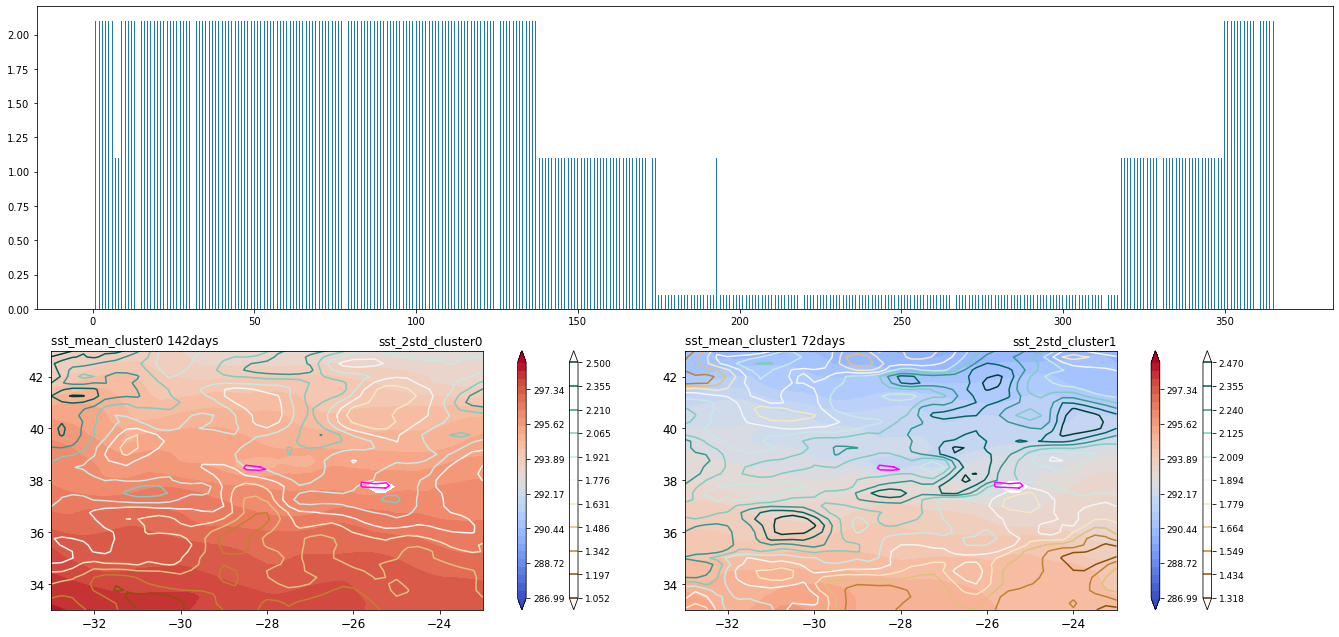

varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]


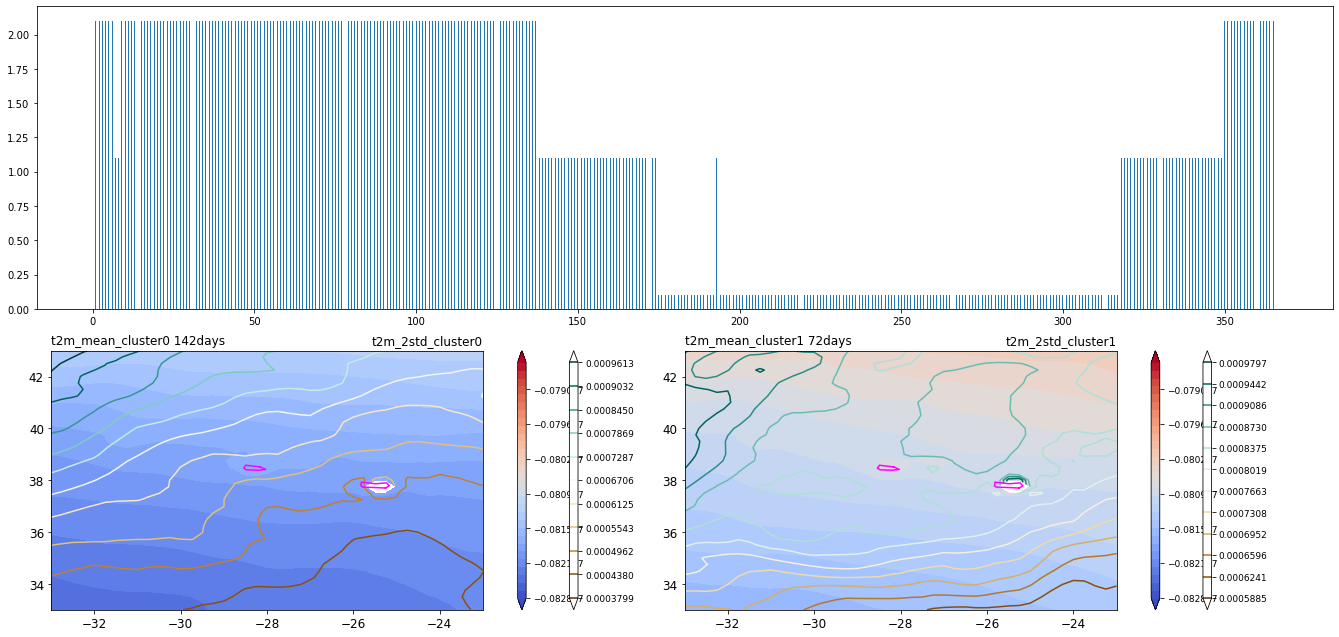

varid: u10
var_range: [-15.129702662479593, 16.82725476413482]


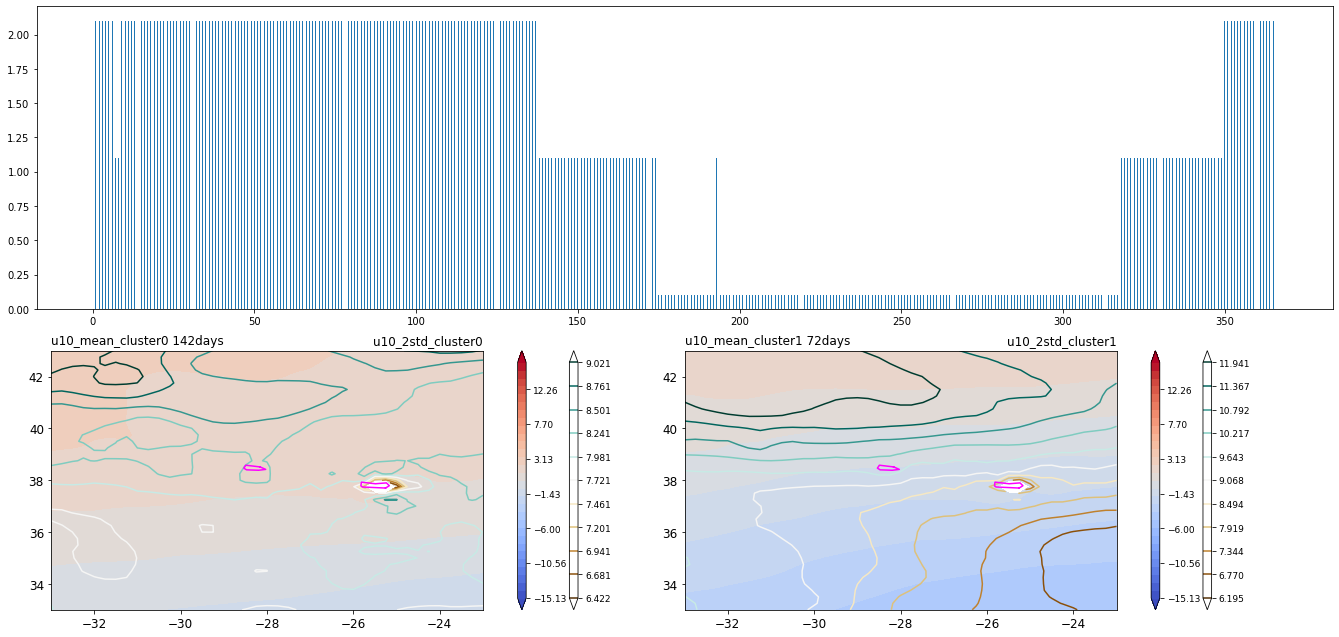

varid: v10
var_range: [-14.294945017569995, 14.039669939743764]


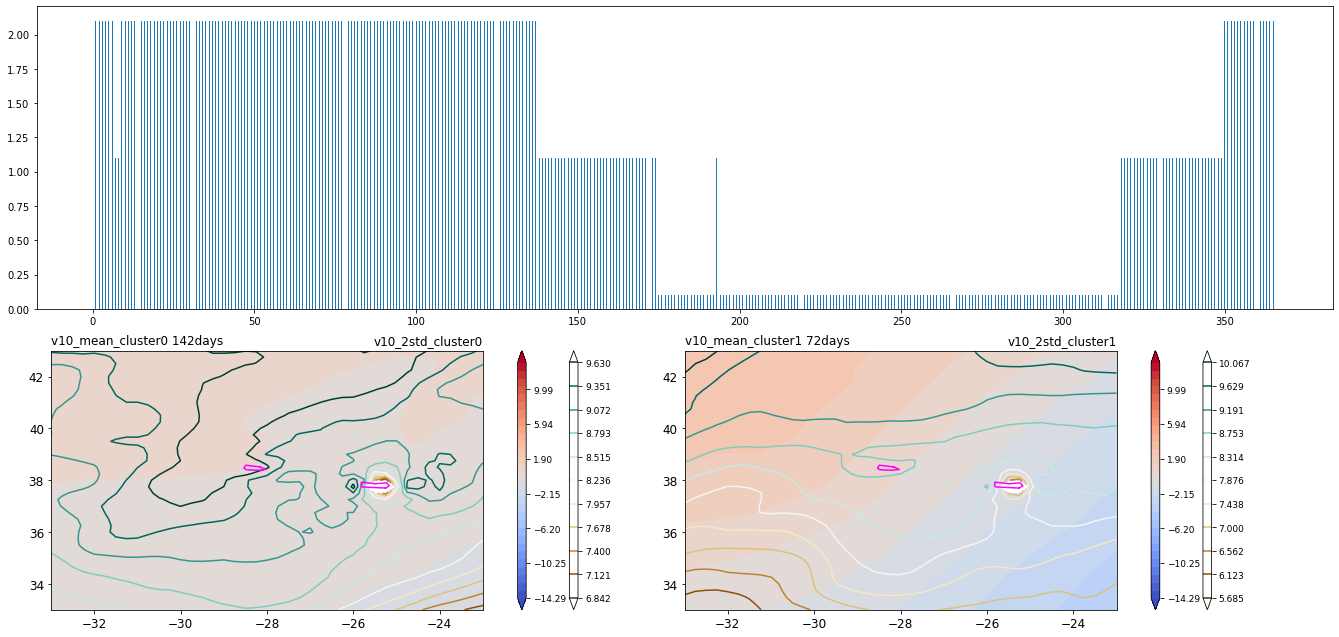

varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]


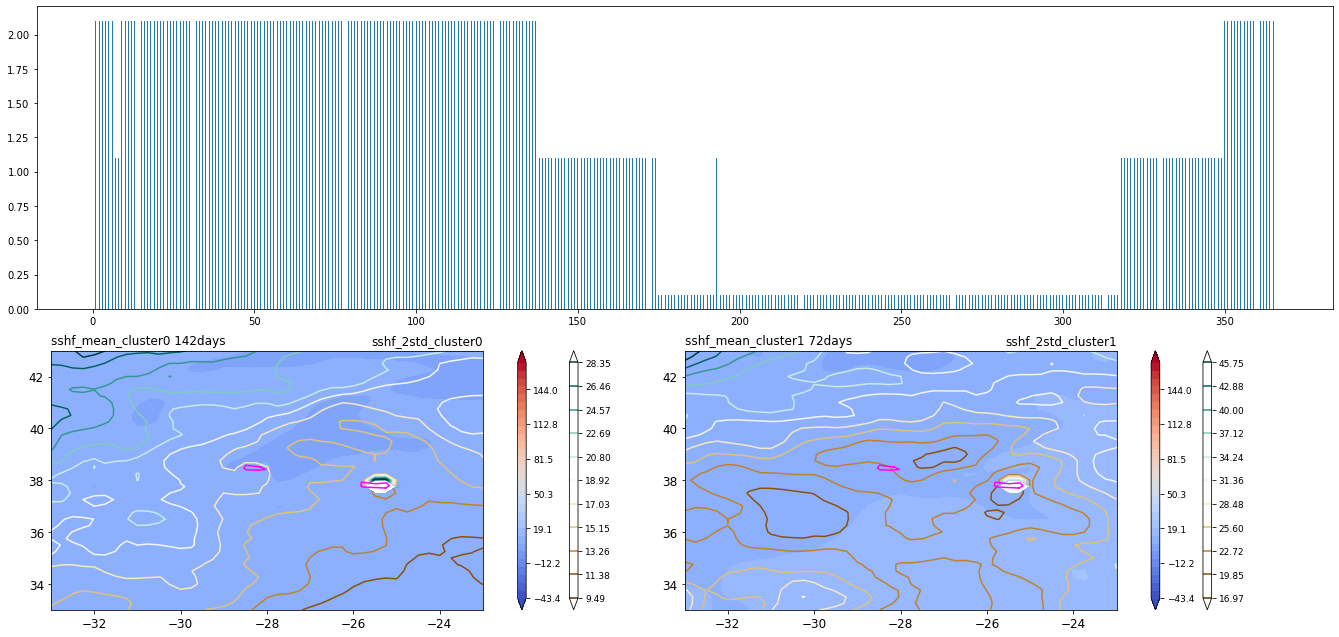

varid: slhf
var_range: [-17443.55070315274, -64.21228143772385]


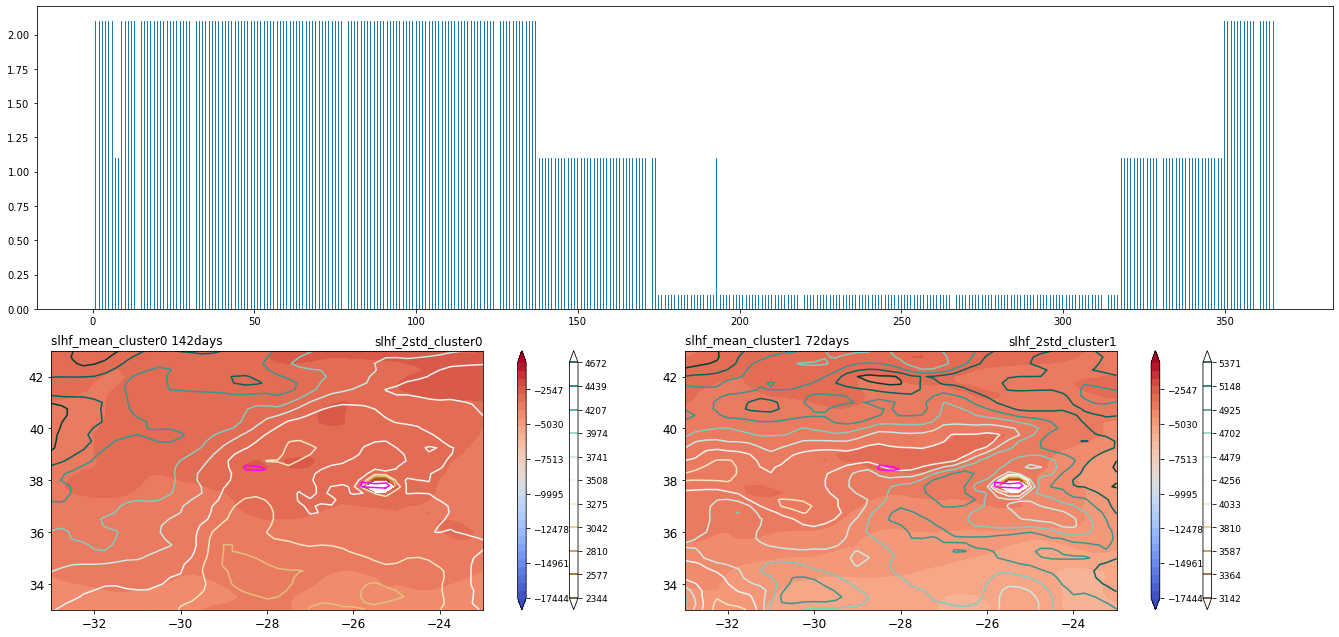

In [ ]:
# Maps implementation with rdata_daily
input_dir = '/content/drive/MyDrive/Courses/IS-700-Independent_Study/'
data_file = 'ERA5_meteo_sfc_2021_daily.nc'
varids=['sst','t2m','u10','v10','sshf','slhf']
ccoefs=[1,-1./3600,1,1,-1./3600,1e-2]
ifplot = True
ERA5_daily_combined_10 ={}
cluster_filename='transformed_data_rdata_daily'
cluster_link = input_dir+cluster_filename+'.csv'
[days,id]=read_combined_cluster(cluster_link,'OK') 
n_cluster = max(id)-min(id)+1
print('n_cluster is:',n_cluster)
width = 0.3
height = 0.5
panels=[(0.06, 0.08,width, height), (0.39, 0.08,width, height),(0.72, 0.08,width, height),
        (0.06, 0.38, width, height), (0.39, 0.38, width, height),(0.72, 0.38, width, height),
        (0.06, 0.68, width, height),(0.39, 0.68, width, height), (0.72, 0.68, width, height),
]
panels=[(0.06, 0.08,width, height), (0.5, 0.08,width, height),(0.05, 0.5,0.9, 0.3),]

for ivar in range(len(varids)):
  fig=plt.figure(1,figsize=[20,14])
  varid = varids[ivar]  
  var_range=[0,1]
  ccoef = ccoefs[ivar] 
  cmap0='coolwarm'
  colorbar = True
  fcase = input_dir+data_file
  fin = Dataset(fcase, "r")
  time = np.squeeze(fin['time'][:])
  lat0 = np.squeeze(fin['latitude'][:])
  lon0 = np.squeeze(fin['longitude'][:])
  sst0 = np.squeeze(fin['sst'][:])
  var0 = ccoef*np.squeeze(fin[varid][:])
  var0[np.isnan(sst0)]=np.nan  
  var_range[0]= np.nanmin(var0)+(np.nanmax(var0)-np.nanmin(var0))*0.05
  var_range[1]=np.nanmax(var0)-(np.nanmax(var0)-np.nanmin(var0))*0.05
  print('varid:',varid)
  print('var_range:',var_range)
  dl=0.25
  dh=0.25
  ddl=0.01
  ddh = 0.01
  for icluster in range(min([n_cluster,max(id),2])):
      days_icluster = days[np.where(id==icluster)[0]]
      ndays_icluster = len(days_icluster)
      time_icluster = np.zeros(ndays_icluster)
      var_icluster = np.zeros([ndays_icluster,len(lat0),len(lon0)])
      for iday in range(ndays_icluster):
          istep = np.where(time==days_icluster[iday])
          time_icluster[iday] = time[istep]
          var_icluster[iday]=  np.squeeze(var0[istep])       
      var_mean_icluster = np.nanmean(var_icluster,axis=0)
      var_std_icluster = 2*np.nanstd(var_icluster,axis=0)            
      ERA5_daily_combined_10[varid+'_mean_'+str(icluster)]= var_mean_icluster 
      ERA5_daily_combined_10[varid+'_std_'+str(icluster)]= var_std_icluster
      if(ivar ==0):  
        ERA5_daily_combined_10['time_'+str(icluster)]= time_icluster
        ERA5_daily_combined_10['days_'+str(icluster)]= days_icluster           

      p = plot_map(var_mean_icluster, var_range,lon0,lat0,fig,panels[icluster],cmap0,colorbar,varid+'_mean_cluster'+str(icluster)+' '+str(len(time_icluster))+'days',ifcontourf=True)
      #The below line has a error
      p = plot_map(var_std_icluster, [np.nanmin(var_std_icluster),np.nanmax(var_std_icluster)] ,lon0,lat0,fig,panels[icluster],'BrBG',colorbar,varid+'_2std_cluster'+str(icluster),ifcontourf=False)
  ax1 = fig.add_axes(panels[2])
  plt.bar(days,id+0.1,width=0.3)
  plt.show()  